In [1]:
import jax.numpy as np
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
config.update("jax_enable_x64", True)
import pandas as pd
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


## Define all 3 models

In [2]:
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s, normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
    
    def Psi1norm(self, I1norm):
        return NODE_vmap(I1norm, self.params_I1)
    
    def Psi2norm(self, I2norm):
        return NODE_vmap(I2norm, self.params_I2)
    
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        return alpha*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        return alpha*NODE_vmap(K, self.params_I1_I4s[:-1])
    
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4s[:-1])

    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm )
        return alpha*NODE_vmap(K, self.params_I4a_I4s[:-1])
    
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm)
        return (1-alpha)*NODE_vmap(K, self.params_I4a_I4s[:-1])

# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
        self.normalization = normalization
        
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the sigma functions expect the gradient so taking derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.normalization[0]
    
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.normalization[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*alpha/self.normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*(1-alpha)/self.normalization[2]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*alpha/self.normalization[0]
    
    # mixed term with I4s and I1
    # output is derivative wrt I4s
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*(1-alpha)/self.normalization[3]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4a
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*alpha/self.normalization[2]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm )
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*(1-alpha)/self.normalization[3]

class CANN_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        # self.params_I4a = params_I4a
        # self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
        self.normalization = normalization
    
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/normalization[0]
    
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/normalization[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*alpha/normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*(1-alpha)/normalization[2]
    
    # mixed term with I4s and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*alpha/normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*(1-alpha)/normalization[3]
    
    # mixed term with I4s and I4a
    # output is derivative wrt I4a
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*alpha/normalization[2]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)-1.0)
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*(1-alpha)/normalization[3]
    

In [3]:
I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_2_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_2_4a_factor = 0.5
Psi_2_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,\
                 Psi1_factor,Psi2_factor,Psi4a_factor,Psi4s_factor,\
                 Psi_1_2_factor,Psi_1_4a_factor,Psi_1_4s_factor,\
                 Psi_2_4a_factor,Psi_2_4s_factor, Psi_4a_4s_factor]

def Psi1(I1, model, norm):
    I1_factor = norm[0]
    Psi1_factor = norm[4]
    Psi_1_2_factor = norm[8]
    Psi_1_4a_factor = norm[9]
    Psi_1_4s_factor = norm[10]
    I1 = I1/I1_factor
    Psi1 = model.Psi1norm(I1)*Psi1_factor
    Psi_1_2 = 0.0
    Psi_4a_1 = model.Psi_4a_1_norm(I1,0.0)*Psi_1_4a_factor
    Psi_4s_1 = model.Psi_4s_1_norm(I1,0.0)*Psi_1_4s_factor
    Psi1 = np.array(Psi1 + Psi_1_2 + Psi_4a_1 + Psi_4s_1).squeeze()
    return Psi1
Psi11 = grad(Psi1)

def Psi2(I2, model, norm):
    I2_factor = norm[1]
    Psi2_factor = norm[5]
    Psi_1_2_factor = norm[8]
    Psi_2_4a_factor = norm[11]
    Psi_2_4s_factor = norm[12]
    I2 = I2/I2_factor
    Psi2 = model.Psi2norm(I2)*Psi2_factor
    Psi_1_2 = 0.0
    Psi_2_4a = 0.0
    Psi_2_4s = 0.0
    Psi2 = np.array(Psi2 + Psi_1_2 + Psi_2_4a + Psi_2_4s).squeeze()
    return Psi2
Psi22 = grad(Psi2)

def Psi4a(I4a, model, norm):
    I4a_factor = norm[2]
    Psi4a_factor = norm[6]
    Psi_1_4a_factor = norm[9]
    Psi_2_4a_factor = norm[11]
    Psi_4a_4s_factor = norm[13]
    I4a = I4a/I4a_factor
    Psi4a = 0.0
    Psi_1_4a = model.Psi_1_4a_norm(0.0,I4a)*Psi_1_4a_factor
    Psi_2_4a = 0.0
    Psi_4s_4a = model.Psi_4s_4a_norm(I4a,0.0)*Psi_4a_4s_factor
    Psi4a = np.array(Psi4a + Psi_1_4a + Psi_2_4a + Psi_4s_4a).squeeze()
    return Psi4a
Psi4a4a = grad(Psi4a)

def Psi4s(I4s, model, norm):
    I4s_factor = norm[3]
    Psi4s_factor = norm[7]
    Psi_1_4s_factor = norm[10]
    Psi_2_4s_factor = norm[12]
    Psi_4a_4s_factor = norm[13]
    I4s = I4s/I4s_factor
    Psi4s = 0.0
    Psi_1_4s = model.Psi_1_4s_norm(0.0,I4s)*Psi_1_4s_factor
    Psi_2_4s = 0.0
    Psi_4a_4s = model.Psi_4a_4s_norm(0.0,I4s)*Psi_4a_4s_factor
    Psi4s = np.array(Psi4s + Psi_1_4s + Psi_2_4s + Psi_4a_4s).squeeze()
    return Psi4s
Psi4s4s = grad(Psi4s)

CANN sx
1.1796952555448494 0.0004064018885853487 -0.02467156587872589 3.212107803862707
ICNN sx
2.3595014985340613e-07 0.589494824529808 1.1055146819662193e-05 3.202699635749222e-07
NODE sx
0.06184689248790302 0.816772099669632 5.0781387696146224e-09 0.6184993708944024
CANN equi
0.004094716972177995 2.736770565095668 -0.1433519694664613 0.0
ICNN equi
5.660122377335519e-07 1.4424175913571584 1.863707352567036e-07 0.004064110240148667
NODE equi
0.00402891764785013 0.3143361635288267 0.05962138817325521 0.06303964978190227
CANN sy
7.916864387291023 3.817675612924272e-05 -0.03070878450550609 0.0
ICNN sy
4.0243151465616425 4.796699372906092e-07 2.7537226457586574e-07 0.011298040516511648
NODE sy
1.0403482500950807 0.3838668428582605 1.0019161315547391 1.5379949555660188e-08
CANN all
0.16571406948674094 1.491673301504381 2.4927242541906613e-12 0.0
ICNN all
1.6535565637314473e-07 0.31477831113465354 1.922482396351125e-09 0.01690082228904499
NODE all
0.4969864559561488 0.5081527781144259 3.871

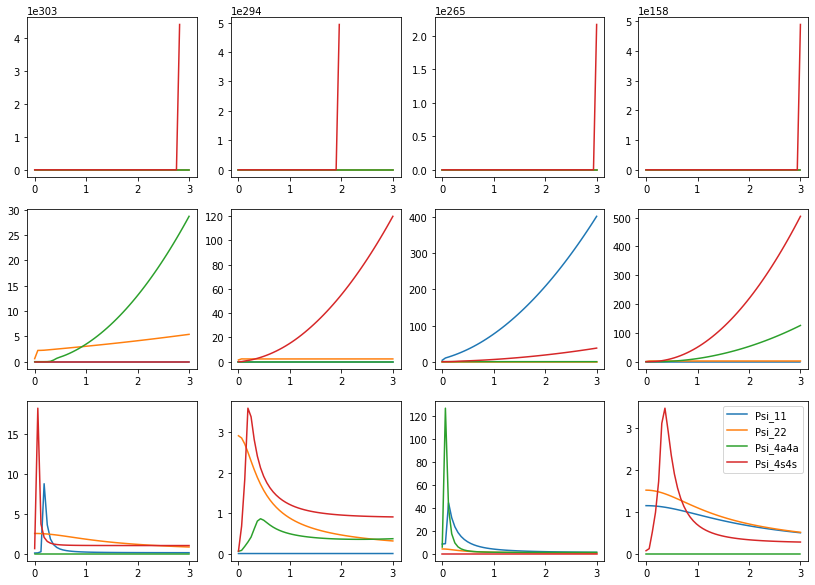

In [6]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
train_cases = ['sx', 'equi', 'sy', 'all']
panels_list = [['a','e','i'],['b','f','j'],['c','g','k'],['d','h','l']]
for ax, train_case, panels in zip(axes.T, train_cases, panels_list):
    models      = [CANN_model, ICNN_model, NODE_model]
    model_names = ['CANN',     'ICNN',     'NODE']
    for axi, MODEL, model_name, panel in zip(ax, models, model_names, panels):
        with open('savednet/'+model_name+'_skinparams_'+train_case+'.npy', 'rb') as f:
            params = pickle.load(f)
        model = MODEL(*params, normalization)
        
        Ii = np.linspace(0,3)
        Psi_11 = []
        Psi_22 = []
        Psi_4a4a = []
        Psi_4s4s = []
        for i in range(Ii.shape[0]):
            I = np.expand_dims(Ii[i],axis=0)
            Psi_11.append(Psi11(I, model, normalization))
            Psi_22.append(Psi22(I, model, normalization))
            Psi_4a4a.append(Psi4a4a(I, model, normalization))
            Psi_4s4s.append(Psi4s4s(I, model, normalization))
        axi.plot(Ii, Psi_11, label='Psi_11')
        axi.plot(Ii, Psi_22, label='Psi_22')
        axi.plot(Ii, Psi_4a4a, label='Psi_4a4a')
        axi.plot(Ii, Psi_4s4s, label='Psi_4s4s')
        print(model_name, train_case)
        print(np.min(np.array(Psi_11)), np.min(np.array(Psi_22)), np.min(np.array(Psi_4a4a)), np.min(np.array(Psi_4s4s)))

        Psi_11 = np.array(Psi_11).squeeze()
        Psi_22 = np.array(Psi_22).squeeze()
        Psi_4a4a = np.array(Psi_4a4a).squeeze()
        Psi_4s4s = np.array(Psi_4s4s).squeeze()

        Psi_11 = np.clip(Psi_11, a_min = 0, a_max = 1000)
        Psi_22 = np.clip(Psi_22, a_min = 0, a_max = 1000)
        Psi_4a4a = np.clip(Psi_4a4a, a_min = 0, a_max = 1000)
        Psi_4s4s = np.clip(Psi_4s4s, a_min = 0, a_max = 1000)

        data = np.array([Ii, Psi_11, Psi_22, Psi_4a4a, Psi_4s4s])
        columns = ['x','Psi11', 'Psi22', 'Psi4a4a', 'Psi4s4s']
        df = pd.DataFrame(data.T, columns=columns)
        df.to_csv('TikZ/fig_skind2_data/'+panel+'.csv', index=False, sep = ' ')
axes[2,3].legend()

Automatic differentiation working now, so no need for everything below:

CANN sx
1.1796952574961301 0.00040640188895459096 -0.024670369913604162 nan
ICNN sx
2.168404344971009e-07 0.5894954663299146 1.1167282376600696e-05 0.0
NODE sx
0.06184689248790301 0.8197886813832156 5.078138769614622e-09 0.6184993708944023
CANN equi
0.004094716972178102 2.736770565095668 -0.14335060916081943 nan
ICNN equi
4.87890977618477e-07 1.442429509168619 1.0842021724855044e-07 0.004064131843561913
NODE equi
0.00402891764785013 0.3135269821541442 0.05962138817325522 0.06303964978190232
CANN sy
7.916864321229345 3.817675662058753e-05 -0.030710677056955404 5.413897751732781e-13
ICNN sy
4.024319072426508 4.607859233063394e-07 0.0 0.011297603477733453
NODE sy
1.0373923942097463 0.3836930773104541 1.0018652574217413 1.537994955566018e-08
CANN all
0.16571401369180894 1.4915846335838978 0.0 2.302178131152055e-12
ICNN all
2.168404344971009e-07 0.3147777177803235 0.0 0.01690076030513854
NODE all
0.4987121826616203 0.5071498776487715 3.871375750478957e-09 0.06738816251056363


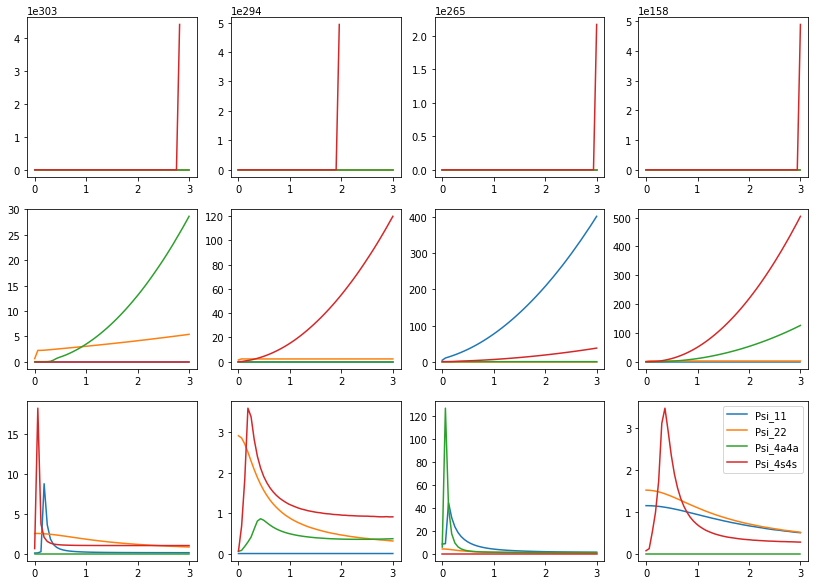

In [7]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
train_cases = ['sx', 'equi', 'sy', 'all']
panels_list = [['a','e','i'],['b','f','j'],['c','g','k'],['d','h','l']]
for ax, train_case, panels in zip(axes.T, train_cases, panels_list):
    models      = [CANN_model, ICNN_model, NODE_model]
    model_names = ['CANN',     'ICNN',     'NODE']
    for axi, MODEL, model_name, panel in zip(ax, models, model_names, panels):
        with open('savednet/'+model_name+'_skinparams_'+train_case+'.npy', 'rb') as f:
            params = pickle.load(f)
        model = MODEL(*params, normalization)
        
        Ii = np.linspace(0,3)
        Psi_11 = []
        Psi_22 = []
        Psi_4a4a = []
        Psi_4s4s = []
        for i in range(Ii.shape[0]):
            I = np.expand_dims(Ii[i],axis=0)
            eps = 1.e-12
            Psi_11.append((Psi1(I+eps, model, normalization)-Psi1(I, model, normalization))/eps)
            Psi_22.append((Psi2(I+eps, model, normalization)-Psi2(I, model, normalization))/eps)
            Psi_4a4a.append((Psi4a(I+eps, model, normalization)-Psi4a(I, model, normalization))/eps)
            Psi_4s4s.append((Psi4s(I+eps, model, normalization)-Psi4s(I, model, normalization))/eps)
        axi.plot(Ii, Psi_11, label='Psi_11')
        axi.plot(Ii, Psi_22, label='Psi_22')
        axi.plot(Ii, Psi_4a4a, label='Psi_4a4a')
        axi.plot(Ii, Psi_4s4s, label='Psi_4s4s')

        Psi_11 = np.array(Psi_11).squeeze()
        Psi_22 = np.array(Psi_22).squeeze()
        Psi_4a4a = np.array(Psi_4a4a).squeeze()
        Psi_4s4s = np.array(Psi_4s4s).squeeze()

        Psi_11 = np.clip(Psi_11, a_min = 0, a_max = 100)
        Psi_22 = np.clip(Psi_22, a_min = 0, a_max = 100)
        Psi_4a4a = np.clip(Psi_4a4a, a_min = 0, a_max = 100)
        Psi_4s4s = np.clip(Psi_4s4s, a_min = 0, a_max = 100)

        data = np.array([Ii, Psi_11, Psi_22, Psi_4a4a, Psi_4s4s])
        columns = ['x','Psi11', 'Psi22', 'Psi4a4a', 'Psi4s4s']
        df = pd.DataFrame(data.T, columns=columns)
        df.to_csv('TikZ/fig_skind2_data/'+panel+'.csv', index=False, sep = ' ')
axes[2,3].legend()

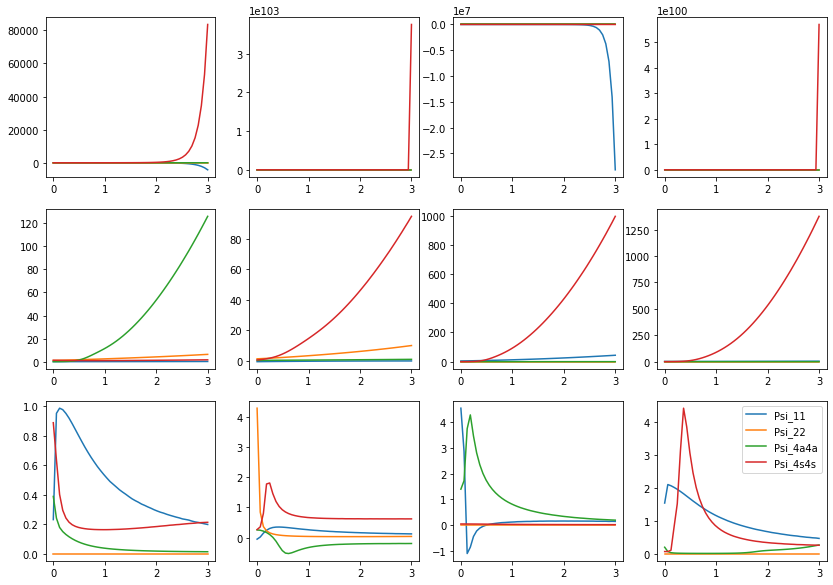

In [51]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
train_cases = ['sx', 'equi', 'sy', 'all']
panels_list = [['a','e','i'],['b','f','j'],['c','g','k'],['d','h','l']]
for ax, train_case, panels in zip(axes.T, train_cases, panels_list):
    models      = [CANN_model, ICNN_model, NODE_model]
    model_names = ['CANN',     'ICNN',     'NODE']
    for axi, MODEL, model_name, panel in zip(ax, models, model_names, panels):
        with open('savednet/'+model_name+'_skinparams_'+train_case+'.npy', 'rb') as f:
            params = pickle.load(f)
        model = MODEL(*params, normalization)
        
        Ii = np.linspace(0,3)
        Psi_11 = []
        Psi_22 = []
        Psi_4a4a = []
        Psi_4s4s = []
        for i in range(Ii.shape[0]):
            I = np.expand_dims(Ii[i],axis=0)
            eps = 1.e-12
            Psi_11.append((Psi1(I+eps, model, normalization)-Psi1(I, model, normalization))/eps)
            Psi_22.append((Psi2(I+eps, model, normalization)-Psi2(I, model, normalization))/eps)
            Psi_4a4a.append((Psi4a(I+eps, model, normalization)-Psi4a(I, model, normalization))/eps)
            Psi_4s4s.append((Psi4s(I+eps, model, normalization)-Psi4s(I, model, normalization))/eps)
        axi.plot(Ii, Psi_11, label='Psi_11')
        axi.plot(Ii, Psi_22, label='Psi_22')
        axi.plot(Ii, Psi_4a4a, label='Psi_4a4a')
        axi.plot(Ii, Psi_4s4s, label='Psi_4s4s')
        

        Psi_11 = np.array(Psi_11).squeeze()
        Psi_22 = np.array(Psi_22).squeeze()
        Psi_4a4a = np.array(Psi_4a4a).squeeze()
        Psi_4s4s = np.array(Psi_4s4s).squeeze()

        Psi_11 = np.clip(Psi_11, a_min = 0, a_max = 100)
        Psi_22 = np.clip(Psi_22, a_min = 0, a_max = 100)
        Psi_4a4a = np.clip(Psi_4a4a, a_min = 0, a_max = 100)
        Psi_4s4s = np.clip(Psi_4s4s, a_min = 0, a_max = 100)

        data = np.array([Ii, Psi_11, Psi_22, Psi_4a4a, Psi_4s4s])
        columns = ['x','Psi11', 'Psi22', 'Psi4a4a', 'Psi4s4s']
        df = pd.DataFrame(data.T, columns=columns)
        df.to_csv('TikZ/fig_skind2_data/'+panel+'.csv', index=False, sep = ' ')
axes[2,3].legend()

What I have seen so far shows that even when differentiated numerically, the second derivatives can be negative. So one of the following must be true:
1. The 2nd derivatives can be negative for polyconvexity.
2. Something is wrong with the 1st derivative functions.
Lets look at the plots of the 1st derivatives.

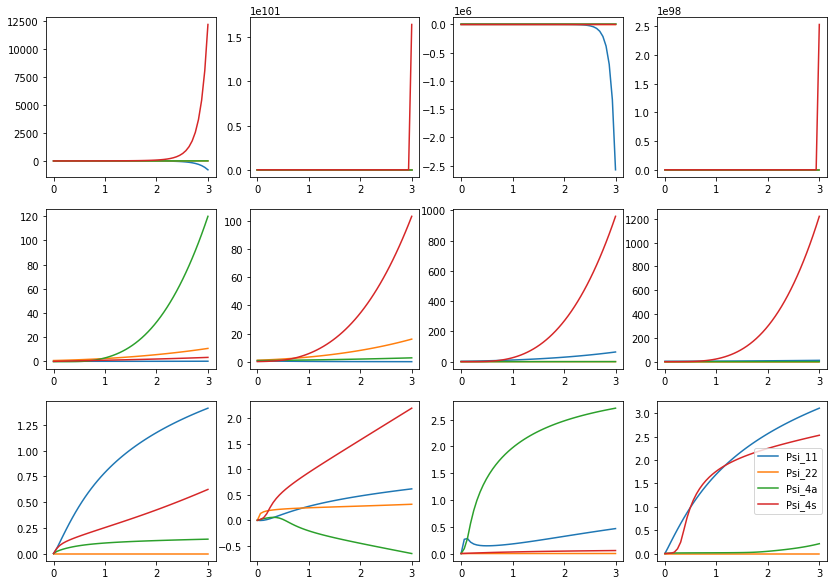

In [5]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
train_cases = ['sx', 'equi', 'sy', 'all']
panels_list = [['a','e','i'],['b','f','j'],['c','g','k'],['d','h','l']]
for ax, train_case, panels in zip(axes.T, train_cases, panels_list):
    models      = [CANN_model, ICNN_model, NODE_model]
    model_names = ['CANN',     'ICNN',     'NODE']
    for axi, MODEL, model_name, panel in zip(ax, models, model_names, panels):
        with open('savednet/'+model_name+'_skinparams_'+train_case+'.npy', 'rb') as f:
            params = pickle.load(f)
        model = MODEL(*params, normalization)
        
        Ii = np.linspace(0,3)
        Psi_1 = Psi1(Ii, model, normalization)
        Psi_2 = Psi2(Ii, model, normalization)
        Psi_4a = Psi4a(Ii, model, normalization)
        Psi_4s = Psi4s(Ii, model, normalization)
        axi.plot(Ii, Psi_1, label='Psi_11')
        axi.plot(Ii, Psi_2, label='Psi_22')
        axi.plot(Ii, Psi_4a, label='Psi_4a')
        axi.plot(Ii, Psi_4s, label='Psi_4s')
axes[2,3].legend()

The first derivatives are supposed to be monotonic (at least for the Neural ODE). But even when I increase the integration steps from 100 to 1000 or use ODEINT we still have some non-monotonic cases, let's look at the trajectories of the ODE.

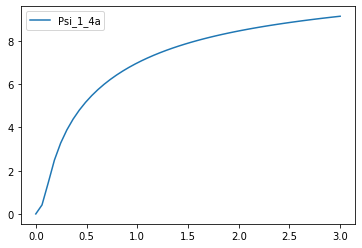

In [10]:
def Psi1(I1, model, norm):
    I1_factor = norm[0]
    Psi1_factor = norm[4]
    Psi_1_2_factor = norm[8]
    Psi_1_4a_factor = norm[9]
    Psi_1_4s_factor = norm[10]
    I1 = I1/I1_factor
    Psi1 = model.Psi1norm(I1)*Psi1_factor
    Psi_1_2 = 0.0
    Psi_1_4a = model.Psi_1_4a_norm(I1,0.0)*Psi_1_4a_factor
    Psi_1_4s = model.Psi_1_4s_norm(I1,0.0)*Psi_1_4s_factor
    Psi1 = np.array(Psi1 + Psi_1_2 + Psi_1_4a + Psi_1_4s).squeeze()
    return Psi1

with open('savednet/NODE_skinparams_sy.npy', 'rb') as f:
    params = pickle.load(f)

model = NODE_model(*params, normalization)
I1 = np.linspace(0,3)
I1norm = I1/I1_factor
Psi1 = model.Psi1norm(I1norm)*Psi1_factor
Psi_1_4a = model.Psi_4a_1_norm(I1norm,0.0)*Psi_1_4a_factor
Psi_1_4s = model.Psi_1_4s_norm(I1norm,0.0)*Psi_1_4s_factor

# plt.plot(I1, Psi1, label='Psi1')
plt.plot(I1, Psi_1_4a, label='Psi_1_4a')
# plt.plot(I1, Psi_1_4s, label='Psi_1_4s')
plt.legend()